## MODELS EXPLORATION
**GOAL**:
In this notebook we will explore different models and compare their performance. We want to predict NO2 levels 3 days ahead.

To create a prediction model for NO2 levels 3 days ahead involves considering several aspects:

1. Variables to Input:
- Historical NO2 Levels: Include historical NO2 level data to capture patterns and trends over time. We will make improvements by adding data from more years.
- Meteorological Conditions: Factors such as temperature, humidity, wind speed can influence NO2 concentration.
- Day of the Week: There are variations depending on the day of the week.
- Hour: We saw strong hourly patterns in the EDA.
- Special Events: Incorporate special events, such as holidays or local events that could affect pollution levels.

2. Historical Data Depth:
        The amount of historical data to consider depends on the periodicity of patterns in NO2 levels. Since there are monthly patterns, we should add data from other years.

3. Modeling Techniques to Test:
        - Time Regression: Use time regression techniques, such as ARIMA (AutoRegressive Integrated Moving Average), which are effective for modeling time series.
        - Machine Learning: Employ supervised learning algorithms to capture complex patterns in temporal data. Since we are working with tabular data, we will focus on gradient boosting techniques (XGBoost, LightGBM, CatBoost) since these have proved to yield the best results.

4. Model Evaluation:
        Split the data into training and test sets to evaluate model performance.
        Use metrics such as mean squared error (MSE) or mean absolute error (MAE) to assess prediction accuracy.

5. Model Optimization:
        Adjust model hyperparameters and test different configurations to improve performance.


In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
import matplotlib
from typing import Tuple

import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve,roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [76]:
df = pd.read_parquet('clean_data.parquet')

As we saw big differences among levels of NO2 among months, we should consider training on more than one year. But in this case we will train with simpler models and only one year of data.

### Transforming our dataset
Since we are trying to predict NO2 levels and in the EDA we saw the importance of the hour, the day of the week and the month (we won't use the month to train since we only have data from one year), we will create those features. And we will simplify the dataset, keeping the hourly average values of all stations.

In [127]:
df = df.groupby('FECHA').agg({'NO2_level': 'mean', 'temp': 'first'}).reset_index()

df['NO2_level'] = df['NO2_level'].round(2)

In [133]:
df['hour'] = df['FECHA'].dt.hour

df['day_of_week'] = df['FECHA'].dt.day_name()

df['month'] = df['FECHA'].dt.month_name()


In [134]:
df

,FECHA,NO2_level,temp,hour,day_of_week,month
0,2018-01-01 00:30:00,13.38,7.3,0,Monday,January
1,2018-01-01 01:30:00,30.04,7.4,1,Monday,January
2,2018-01-01 02:30:00,30.67,6.8,2,Monday,January
3,2018-01-01 03:30:00,20.42,7.1,3,Monday,January
4,2018-01-01 04:30:00,16.96,5.3,4,Monday,January
...,...,...,...,...,...,...
8754,2018-12-31 19:30:00,137.38,5.5,19,Monday,December
8755,2018-12-31 20:30:00,136.00,3.6,20,Monday,December
8756,2018-12-31 21:30:00,132.33,2.9,21,Monday,December
8757,2018-12-31 22:30:00,108.00,1.5,22,Monday,December


#### Dividing our columns

In [135]:
df.columns

Index(['FECHA', 'NO2_level', 'temp', 'hour', 'day_of_week', 'month'], dtype='object')

In [136]:
info_cols = 'FECHA'
label_col = 'NO2_level'
features_cols = [col for col in df.columns if col not in info_cols + label_col]

categorical_cols = ['day_of_week', 'month']
numerical_cols = [col for col in features_cols if col not in categorical_cols]


In [137]:
numerical_cols

['temp', 'hour']

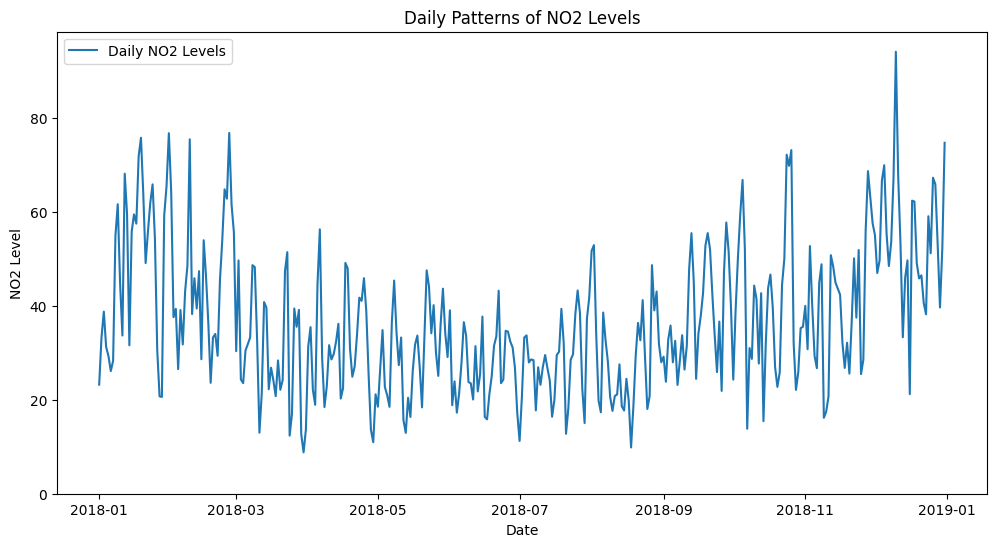

In [138]:
# Plotting daily average NO2 levels
daily_avg = df.groupby(df.FECHA.dt.date)['NO2_level'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_avg.index, y=daily_avg, label='Daily NO2 Levels')

plt.title('Daily Patterns of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.ylim(0)
plt.show()

As we saw during our Exploratory Data Analysis, there is a strong temporal evolution in the data reflecting the monthly variations. Therefore we cannot assume that the pollution dynamics are the same across the months (we should train on data from more years).

It makes sense to do a temporal split. By doing so, we also make sure that we can't use data from the future to train our models which would be a clear example of information leakage.


In [139]:
# Order our data by date
df = df.sort_values(by = 'FECHA')

In [141]:
len(df)

8759

In [213]:

total_hours = len(df)

# calculate cutoff indexes for the train, validation and test sets
train_cutoff = int(0.7 * total_hours)
val_cutoff = int(0.9 * total_hours)

# Divide el DataFrame en conjuntos de train, validation y test
train_df = df.iloc[:train_cutoff]
val_df = df.iloc[train_cutoff:val_cutoff]
test_df = df.iloc[val_cutoff:]

print("Train since:", train_df['FECHA'].min())
print("Train until:", train_df['FECHA'].max())
print("Validation until:", val_df['FECHA'].max())
print("Test until:", test_df['FECHA'].max())


Train since: 2018-01-01 00:30:00
Train until: 2018-09-13 11:30:00
Validation until: 2018-11-25 11:30:00
Test until: 2018-12-31 23:30:00



### Baseline

In order to understand if a ML approach yields any value, we need to compare it against some baseline that does not require training. Here we will use the the average NO2_level of those days in January as the baseline.



In [143]:
# Calculate the mean of NO2 for each day of the week in the train set
baseline_model = train_df.groupby('day_of_week')['NO2_level'].mean().reset_index()
baseline_model

,day_of_week,NO2_level
0,Friday,36.902766
1,Monday,33.977601
2,Saturday,26.902488
3,Sunday,23.728621
4,Thursday,37.378322
5,Tuesday,36.916768
6,Wednesday,37.168356


In [156]:
# Function to predict any day based on the day of the week mean
def predict_day(day_of_week):
    return baseline_model[baseline_model['day_of_week'] == day_of_week]['NO2_level'].values[0]


In [158]:
prediction = predict_day('Thursday')
print(f"Prediction for Thursday {prediction} (day of the week mean)")

Prediction for Thursday 37.37832191780822 (day of the week mean)


In [182]:
val_preds = val_df['day_of_week'].apply(predict_day)

# Calculate metrics
baseline_mae = mean_absolute_error(val_df[label_col], val_preds)
baseline_mse = mean_squared_error(val_df[label_col], val_preds)
baseline_rmse = np.sqrt(mse)

print(f'MAE: {baseline_mae}')
print(f'MSE: {baseline_mse}')
print(f'RMSE: {baseline_rmse}')

MAE: 17.510211997450448
MSE: 613.7832418109605
RMSE: 24.774649176344766


### XGBoost Models

In [164]:
train_cols = ['temp', 'hour', 'day_of_week']

In [165]:
train_df[train_cols]

,temp,hour,day_of_week
0,7.3,0,Monday
1,7.4,1,Monday
2,6.8,2,Monday
3,7.1,3,Monday
4,5.3,4,Monday
...,...,...,...
6126,16.7,7,Thursday
6127,19.4,8,Thursday
6128,22.6,9,Thursday
6129,25.9,10,Thursday


Let's encode our variable day_of_week. Let's use one-hot encoding

In [168]:
df_encoded = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

We make the same split again

In [173]:
train_dfe = df_encoded.iloc[:train_cutoff]
val_dfe = df_encoded.iloc[train_cutoff:val_cutoff]
test_dfe = df_encoded.iloc[val_cutoff:]

And we rename the train_cols

In [170]:
df_encoded.columns

Index(['FECHA', 'NO2_level', 'temp', 'hour', 'month', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [177]:
train_cols = ['temp', 'hour', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday']

In [178]:
# Create an XGBoost regression model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(train_dfe[train_cols], train_dfe[label_col])

# Make predictions on the validation set
xgb_preds = xgb_model.predict(val_dfe[train_cols])

# Evaluate the model
xgb_mae = mean_absolute_error(val_dfe[label_col], xgb_preds)
xgb_mse = mean_squared_error(val_dfe[label_col], xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)

print(f'XGBoost MAE: {xgb_mae}')
print(f'XGBoost MSE: {xgb_mse}')
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoost MAE: 16.36435067659099
XGBoost MSE: 568.0628578676611
XGBoost RMSE: 23.83406926791271


### LightGBM

In [179]:
train_cols = ['temp', 'hour', 'day_of_week']

In [180]:
# Create a LightGBM regression model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Train the model
lgb_model.fit(train_df[train_cols], train_df[label_col])

# Make predictions on the validation set
lgb_preds = lgb_model.predict(val_df[train_cols])

# Evaluate the model
lgb_mae = mean_absolute_error(val_df[label_col], lgb_preds)
lgb_mse = mean_squared_error(val_df[label_col], lgb_preds)
lgb_rmse = np.sqrt(lgb_mse)

print(f'LightGBM MAE: {lgb_mae}')
print(f'LightGBM MSE: {lgb_mse}')
print(f'LightGBM RMSE: {lgb_rmse}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 6131, number of used features: 3
[LightGBM] [Info] Start training from score 33.323871
LightGBM MAE: 15.671473842097589
LightGBM MSE: 532.1062653255702
LightGBM RMSE: 23.06742866739963


#### Models comparison

In [183]:
print("Baseline Model:")
print(f'MAE: {baseline_mae}')
print(f'MSE: {baseline_mse}')
print(f'RMSE: {baseline_rmse}')
print("\nXGBoost Model:")
print(f'MAE: {xgb_mae}')
print(f'MSE: {xgb_mse}')
print(f'RMSE: {xgb_rmse}')
print("\nLightGBM Model:")
print(f'MAE: {lgb_mae}')
print(f'MSE: {lgb_mse}')
print(f'RMSE: {lgb_rmse}')

Baseline Model:
MAE: 17.510211997450448
MSE: 613.7832418109605
RMSE: 24.774649176344766

XGBoost Model:
MAE: 16.36435067659099
MSE: 568.0628578676611
RMSE: 23.83406926791271

LightGBM Model:
MAE: 15.671473842097589
MSE: 532.1062653255702
RMSE: 23.06742866739963


### Insights
- Both XGBoost and LightGBM outperform the baseline model across all metrics.

- LightGBM has lower MAE, MSE, and RMSE compared to XGBoost, indicating better predictive performance.

- The Machine Learning models are providing more accurate predictions than the baseline model.

### Arima Models

In [197]:
arima_train_cols = ['temp', 'hour', 'NO2_level']

In [198]:
arima_train_cols

['temp', 'hour', 'NO2_level']

In [206]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

train, val, test = df.iloc[:train_size], df.iloc[train_size:train_size + val_size], df.iloc[train_size + val_size:]


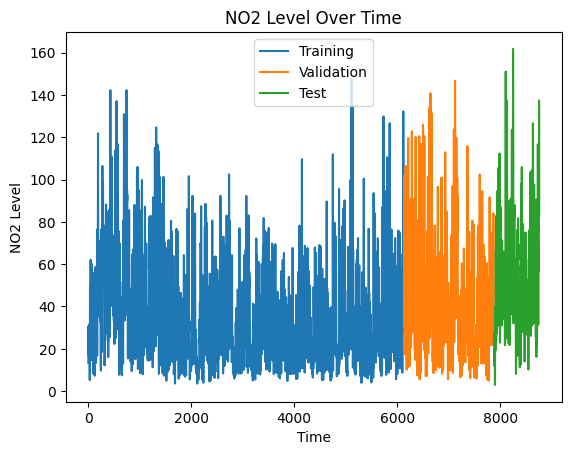

In [207]:
# Plot NO2 levels over time
plt.plot(train['NO2_level'], label='Training')
plt.plot(val['NO2_level'], label='Validation')
plt.plot(test['NO2_level'], label='Test')
plt.xlabel('Time')
plt.ylabel('NO2 Level')
plt.title('NO2 Level Over Time')
plt.legend()
plt.show()

Next steps: 
- Create the ARIMA model
- Hyperparameters optimization, feature engineering, etc
- Training on more data
- Make scripts and call the APIs to keep the model updated, etc